In [148]:
import sys
import os
import numpy as np
import pandas as pd

from sklearn.feature_selection import SequentialFeatureSelector,RFECV
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
# need to be able to import src
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# absolute path to the src directory
src_path = os.path.abspath("../src")

# Add src directory to system path
sys.path.append(src_path)

# get the /MLCBAss1/Assignment-1 path
ass_path=sys.path[-2]

print(ass_path)


%load_ext autoreload
%autoreload 2

from functions import *

/home/sdi1700187/MLCBAss1/Assignment-1
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
# we load the two datasets
dev_set_df=pd.read_csv("../data/development_final_data.csv")
val_set_df=pd.read_csv("../data/evaluation_final_data.csv")

dev_set_df=dev_set_df.drop(labels=['Unnamed: 0'],axis=1)
val_set_df=val_set_df.drop(labels=['Unnamed: 0'],axis=1)

dev_set_df.head()
# val_set_df.head()
bacteria=get_bacteria(dev_set_df,mode='analysis')
bacteria_names=bacteria.columns
y_train=scale_data(pd.DataFrame(dev_set_df["BMI"]),['BMI'])
y_train=y_train['BMI']
x_train=scale_data(bacteria,bacteria_names)

bacteria_val=get_bacteria(val_set_df,mode='analysis')
bacteria_names_val=bacteria_val.columns
y_val=scale_data(pd.DataFrame(val_set_df["BMI"]),['BMI'])
y_val=y_val['BMI']
x_val=scale_data(bacteria_val,bacteria_names_val)


In [95]:
models_dir="../models"

model_io=IO(models_dir)

baseline_predictor=DefaultPredictor()

In [96]:
# Baseline models

# train models
baseline_models=baseline_predictor.train_models(x_train=x_train,y_train=y_train)

# save models
for name,model in baseline_models.items():
    model_io.save(model,name,suf='bsln')

In [98]:
# Bayesian Ridge
baseline_bayesian_evaluator=Evaluator(model=model_io.load('BayesianRidge',suf='bsln'),name='BayesianRidge')
baseline_bayesian_evaluator.evaluate(x=x_val,y=y_val)

baseline_bayesian_report=baseline_bayesian_evaluator.report()
baseline_bayesian_report.head()

,mean,std,median,CIlow,CIhigh
RMSE,0.9373,0.0516,0.9372,0.8368,1.0375
MAE,0.6905,0.0413,0.6918,0.6103,0.7690
R2,0.1112,0.0490,0.1122,0.0094,0.2027


In [99]:
# we evaluate the baseline models

# Elastic Net
baseline_elastic_evaluator=Evaluator(model=model_io.load('ElasticNet',suf='bsln'),name='ElasticNet')
baseline_elastic_evaluator.evaluate(x=x_val,y=y_val)

baseline_elastic_report=baseline_elastic_evaluator.report()
baseline_elastic_report.head()

,mean,std,median,CIlow,CIhigh
RMSE,0.9974,0.0507,0.9989,0.8906,1.1033
MAE,0.8000,0.0391,0.8025,0.7209,0.8800
R2,-0.0054,0.0070,-0.0023,-0.0260,-0.0000


In [100]:
# SVR
baseline_svr_evaluator=Evaluator(model=model_io.load('SVR',suf='bsln'),name='SVR')
baseline_svr_evaluator.evaluate(x=x_val,y=y_val)

baseline_svr_report=baseline_svr_evaluator.report()
baseline_svr_report.head()

,mean,std,median,CIlow,CIhigh
RMSE,0.8810,0.0502,0.8809,0.7833,0.9808
MAE,0.6189,0.0403,0.6177,0.5391,0.6993
R2,0.2145,0.0492,0.2182,0.1113,0.3052


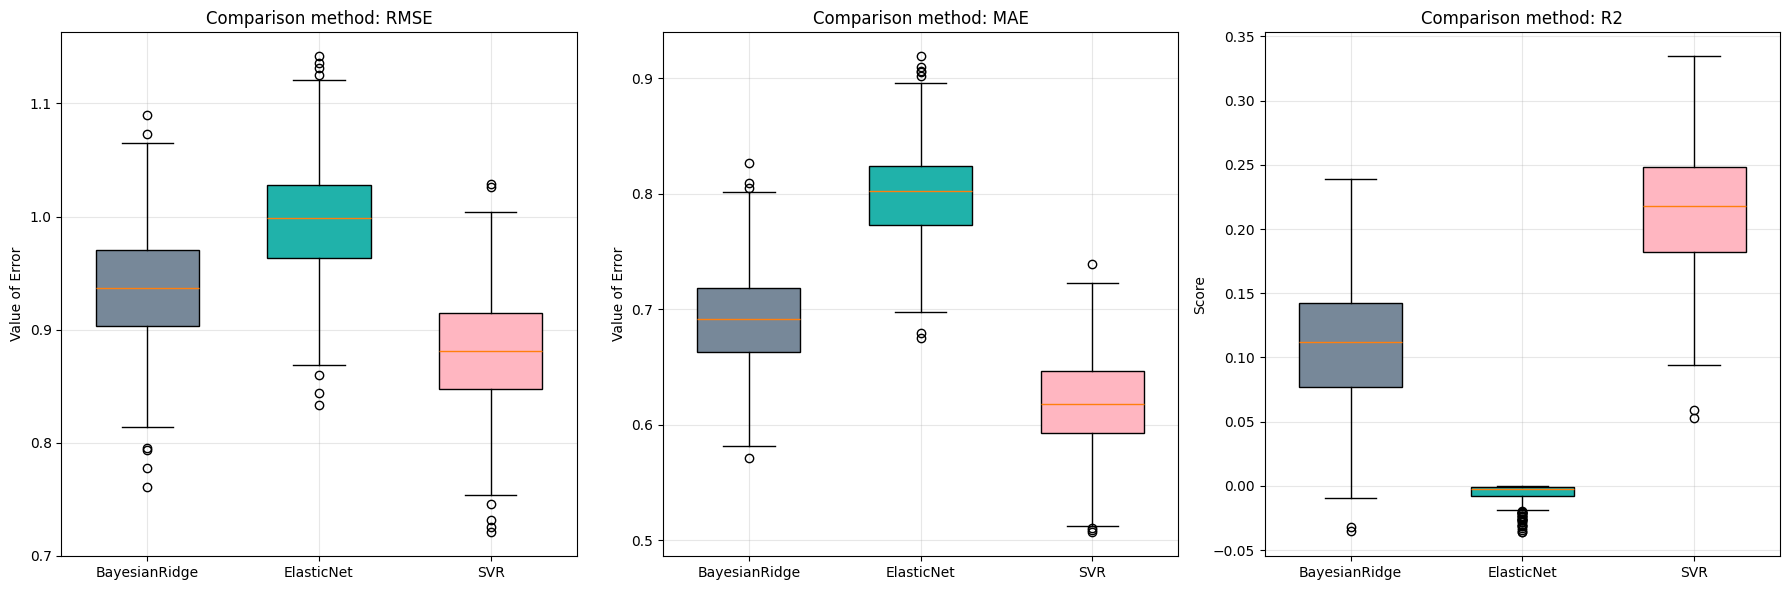

In [101]:
# we visualize the comparison between the methods
viz_comparison(baseline_bayesian_evaluator,baseline_elastic_evaluator,baseline_svr_evaluator)

In [104]:
# Feature selection
# Maybe feature select just on SVR?

selector=RFECV(DecisionTreeRegressor(random_state=42),cv=5,scoring='neg_root_mean_squared_error')
selector=selector.fit(x_train,y_train)

final=selector.support_
total_final=selector.n_features_

print(f"Optimal number of features is {total_final}")
print(f"These are the following {x_train.columns[final]}")


Optimal number of features is 106
These are the following Index(['Acholeplasma axanthum', 'Akkermansia muciniphila',
       'Alistipes finegoldii', 'Alistipes onderdonkii', 'Alistipes putredinis',
       'Alistipes shahii', 'Anaerofilum pentosovorans',
       'Anaerostipes butyraticus', 'Anaerostipes caccae',
       'Anaerotruncus colihominis',
       ...
       'Ruminococcus flavefaciens', 'Ruminococcus gnavus',
       'Ruminococcus sp. DSM 100440', 'Sporobacter termitidis',
       'Streptococcus infantarius', 'Streptococcus mitis',
       'Streptococcus oralis', 'Sutterella parvirubra',
       'Thermobaculum terrenum', 'Victivallis sp. MC_44'],
      dtype='object', length=106)


In [105]:

x_train_fs=x_train.loc[:,final]
x_val_fs=x_val.loc[:,final]


fs_predictor=DefaultPredictor()


# Feature selecet baseline models

# train models
fs_models=fs_predictor.train_models(x_train=x_train_fs,y_train=y_train)

# save models
for name,model in fs_models.items():
    model_io.save(model,name,suf='fs')

In [106]:
# we evaluate the feature selected baseline models

# Bayesian Ridge
fs_bayesian_evaluator=Evaluator(model=model_io.load('BayesianRidge',suf='fs'),name='BayesianRidge')
fs_bayesian_evaluator.evaluate(x=x_val_fs,y=y_val)

fs_bayesian_report=fs_bayesian_evaluator.report()
fs_bayesian_report.head()

,mean,std,median,CIlow,CIhigh
RMSE,0.9334,0.0514,0.9338,0.8371,1.0311
MAE,0.6884,0.0414,0.6883,0.6093,0.7681
R2,0.1184,0.0519,0.1210,0.0080,0.2226


In [107]:

# Elastic Net
fs_elastic_evaluator=Evaluator(model=model_io.load('ElasticNet',suf='fs'),name='ElasticNet')
fs_elastic_evaluator.evaluate(x=x_val_fs,y=y_val)

fs_elastic_report=fs_elastic_evaluator.report()
fs_elastic_report.head()

,mean,std,median,CIlow,CIhigh
RMSE,0.9974,0.0507,0.9989,0.8906,1.1033
MAE,0.8000,0.0391,0.8025,0.7209,0.8800
R2,-0.0054,0.0070,-0.0023,-0.0260,-0.0000


In [108]:
# SVR
fs_svr_evaluator=Evaluator(model=model_io.load('SVR',suf='fs'),name='SVR')
fs_svr_evaluator.evaluate(x=x_val_fs,y=y_val)

fs_svr_report=fs_svr_evaluator.report()
fs_svr_report.head()

,mean,std,median,CIlow,CIhigh
RMSE,0.8764,0.0500,0.8759,0.7776,0.9750
MAE,0.6161,0.0404,0.6144,0.5358,0.6984
R2,0.2227,0.0510,0.2272,0.1201,0.3201


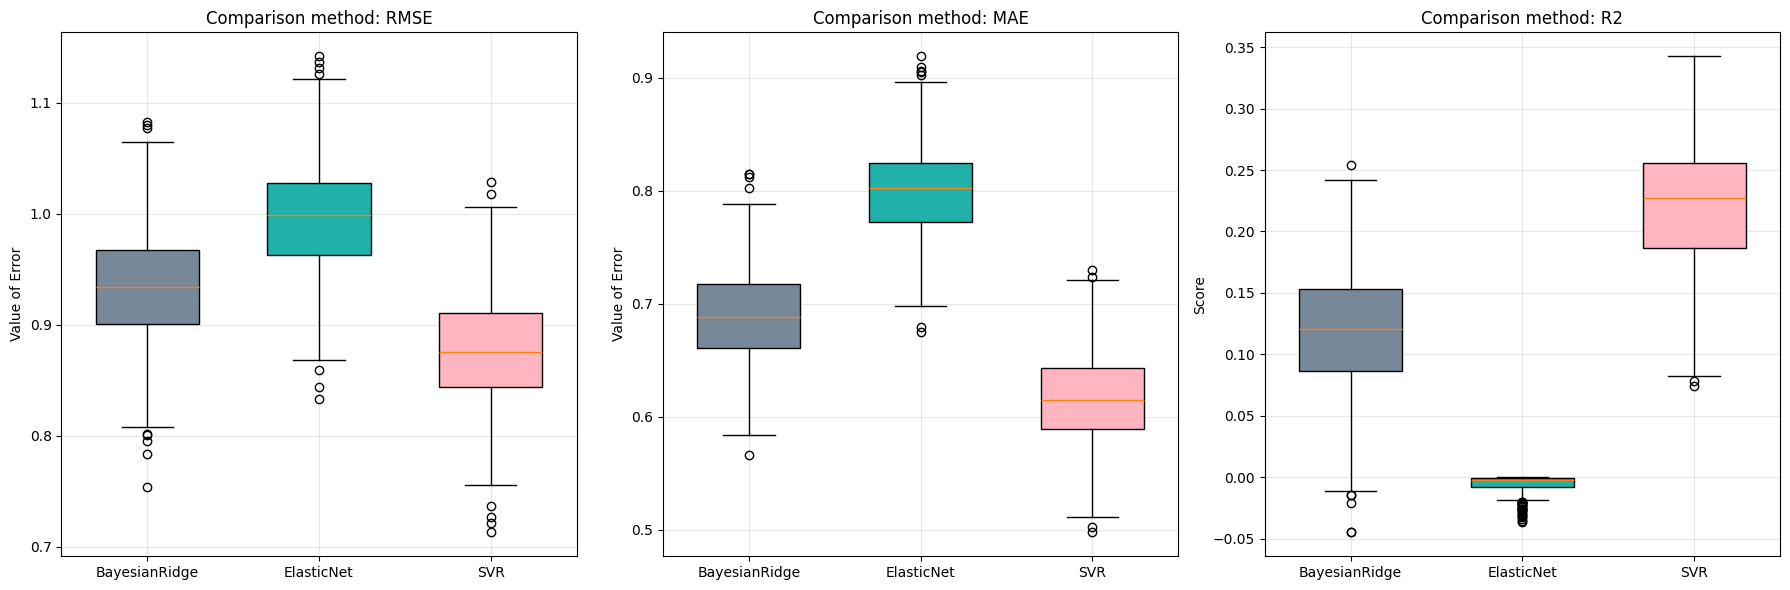

In [109]:
# we visualize the comparison between the methods
viz_comparison(fs_bayesian_evaluator,fs_elastic_evaluator,fs_svr_evaluator)

In [110]:
# Hyperparameter  tuning

ht_predictor=TunedPredictor()
x_train_ht=x_train_fs
x_val_ht=x_val_fs
# train models
ht_models=ht_predictor.train_models(x_train=x_train_ht,y_train=y_train)

# save models
for name,model in ht_models.items():
    print(f"For regressor {name} the best hyperparameters are: {model.best_params_}")
    model_io.save(model,name,suf='hyper')

For regressor BayesianRidge the best hyperparameters are: {'alpha_1': 1e-07, 'alpha_2': 1e-05, 'lambda_1': 1e-05, 'lambda_2': 1e-07, 'lambda_init': 2.0}
For regressor ElasticNet the best hyperparameters are: {'alpha': 0.1, 'l1_ratio': 0.3, 'positive': False, 'selection': 'random', 'warm_start': False}
For regressor SVR the best hyperparameters are: {'C': 0.7, 'epsilon': 0.2, 'gamma': 'auto', 'shrinking': True}


In [111]:
# we evaluate the feature selected hyper-tuned models

# Bayesian Ridge
ht_bayesian_evaluator=Evaluator(model=model_io.load('BayesianRidge',suf='hyper'),name='BayesianRidge')
ht_bayesian_evaluator.evaluate(x=x_val_ht,y=y_val)

ht_bayesian_report=ht_bayesian_evaluator.report()
ht_bayesian_report.head()

,mean,std,median,CIlow,CIhigh
RMSE,0.9334,0.0514,0.9338,0.8371,1.0311
MAE,0.6884,0.0414,0.6883,0.6093,0.7681
R2,0.1184,0.0519,0.1210,0.0080,0.2226


In [112]:
# Elastic Net
ht_elastic_evaluator=Evaluator(model=model_io.load('ElasticNet',suf='hyper'),name='ElasticNet')
ht_elastic_evaluator.evaluate(x=x_val_ht,y=y_val)

ht_elastic_report=ht_elastic_evaluator.report()
ht_elastic_report.head()

,mean,std,median,CIlow,CIhigh
RMSE,0.9255,0.0520,0.9234,0.8296,1.0309
MAE,0.6789,0.0410,0.6797,0.5974,0.7583
R2,0.1336,0.0461,0.1341,0.0380,0.2267


In [113]:
# SVR
ht_svr_evaluator=Evaluator(model=model_io.load('SVR',suf='hyper'),name='SVR')
ht_svr_evaluator.evaluate(x=x_val_ht,y=y_val)

ht_svr_report=ht_svr_evaluator.report()
ht_svr_report.head()

,mean,std,median,CIlow,CIhigh
RMSE,0.8812,0.0504,0.8811,0.7842,0.9824
MAE,0.6280,0.0403,0.6266,0.5479,0.7098
R2,0.2144,0.0460,0.2173,0.1214,0.3017


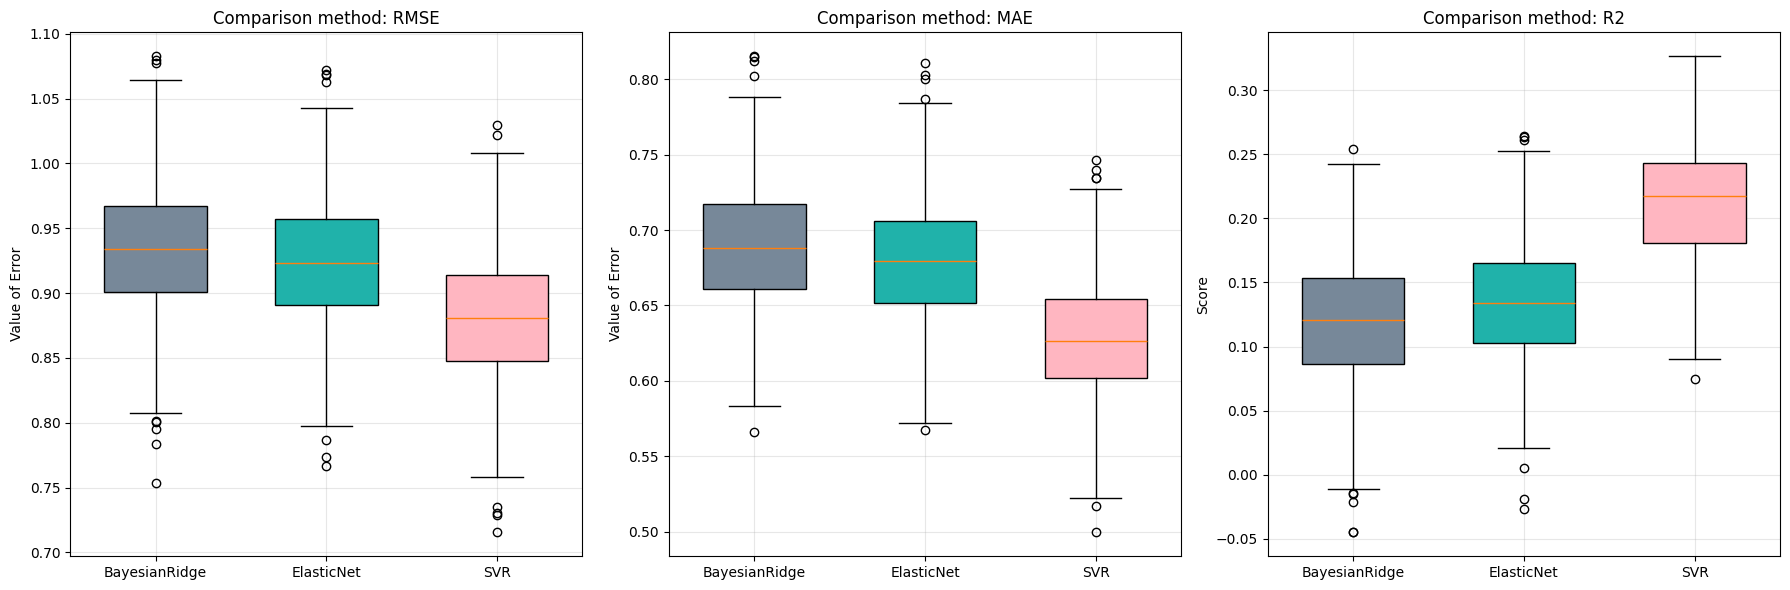

In [114]:
# we visualize the comparison between the methods
viz_comparison(ht_bayesian_evaluator,ht_elastic_evaluator,ht_svr_evaluator)

In [ ]:
final_dir="../final_models"
final_model_io=IO(final_dir)

In [116]:
# Save best models for each method

# Bayesian Ridge
bayesian_best=model_io.load('BayesianRidge',suf='hyper')
final_model_io.save(bayesian_best,'BayesiaRidge',suf='best')


In [117]:
# Elastic Net
elastic_best=model_io.load('ElasticNet',suf='hyper')
final_model_io.save(elastic_best,'ElasticNet',suf='best')

In [118]:
# SVR
svr_best=model_io.load('SVR',suf='fs')
final_model_io.save(svr_best,'SVR',suf='best')

In [ ]:
# we megre the two y's
df_y_train=pd.DataFrame(y_train,columns=['BMI'])
df_y_val=pd.DataFrame(y_val,columns=['BMI'])

df_y_merged=pd.concat([df_y_train,df_y_val])
y_merged=df_y_merged['BMI']

In [146]:
# we merge the two x's
names_train=list(x_train_fs.columns)
df_x_train=pd.DataFrame(x_train_fs,columns=names_train)

names_val=list(x_val_fs.columns)
df_x_val=pd.DataFrame(x_val_fs,columns=names_val)

df_x_merged=pd.concat([df_x_train,df_x_val])
x_merged=df_x_merged.loc[:,names_val]


In [ ]:
# we load our best model

winner=final_model_io.load(name='SVR',suf='best')

winner_pipeline= Pipeline([
    ('scaler', RobustScaler()),  
    ('transformer', PowerTransformer(method='yeo-johnson')),
    ('feature_selection',RFECV(DecisionTreeRegressor(random_state=42),cv=5,scoring='neg_root_mean_squared_error')),
    ('model',winner)
    ])

winner_pipeline.fit(X=x_merged,y=y_merged)
final_model_io.save(winner_pipeline,name='winner',suf='')

Pipeline(steps=[('scaler', RobustScaler()), ('transformer', PowerTransformer()),
                ('feature_selection',
                 RFECV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
                       scoring='neg_root_mean_squared_error')),
                ('model', SVR())])